Overview of Deep learning in Quantitative Finance with Pytorch

Simulate a Delta hedge of a Black-Scholes model

dx/x = sigma dW

For a call option over one time step

In [23]:
import torch

class LSTM(torch.nn.Module):
    def __init__(self, input_size=1, batch_size=10, hidden_layer_size=256, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.batch_size = batch_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

        self.init_hidden()

    def init_hidden(self):
        self.hidden_cell = (torch.zeros(1,self.batch_size,self.hidden_layer_size),
                            torch.zeros(1,self.batch_size,self.hidden_layer_size))


    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions

def entropy_loss(x,d=20):
    return 1./d*torch.log(torch.mean(torch.exp(-d*x)))

In [24]:
batch_size = 4000

epochs = 10
training_size = 50
seq_len = 20
input_dim = 1
risk_aversion = 20
sigma = 0.2

In [25]:
model = LSTM(batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [26]:
for i in range(epochs):
    for j in range(training_size):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, model.batch_size, model.hidden_layer_size),
                        torch.zeros(1, model.batch_size, model.hidden_layer_size))

        # Initial model price is 0
        x0 = torch.zeros(batch_size, seq_len + 1, input_dim)

        # One step simulation
        dx = torch.randn(batch_size, seq_len, input_dim)

        for k in range(seq_len):
            x0[:,k+1,:] = x0[:,k,:] + sigma * dx[:,k,:]

        delta = model(x0[:,:-1,:])

        # Payoff being pi = max(dx-0,0)
        payoff = torch.max(x0[:,-1,:],torch.tensor(0.))

        # Hedge performance pnl = pi - delta * dx
            
        pnl = torch.zeros(batch_size, input_dim)
        delta_zero = torch.zeros(batch_size, input_dim)

        for k in range(seq_len):
            pnl = pnl + (delta[:,k,:]-delta_zero)  * x0[:,k,:]
            delta_zero = delta[:,k,:]

        pnl = pnl + payoff - delta[:,-1,:]*x0[:,-1,:]

        # Loss function is a mean variance optimisation
        loss = -torch.mean(pnl) + risk_aversion * torch.norm(pnl)

        # Propagate derivates
        loss.backward()
        # Optimize
        optimizer.step()
    # Print some deltas
    print(delta[0:5,:,0])

    print(f'Epoch number: {i:3} mean variance loss: {loss.item():10.6f}')


tensor([[0.0706, 0.1099, 0.1409, 0.1680, 0.1935, 0.2095, 0.2140, 0.2218, 0.2312,
         0.2411, 0.2528, 0.2663, 0.2809, 0.2927, 0.2968, 0.2992, 0.2980, 0.2940,
         0.2873, 0.2852],
        [0.0706, 0.1158, 0.1583, 0.1972, 0.2334, 0.2640, 0.2908, 0.3113, 0.3246,
         0.3334, 0.3471, 0.3621, 0.3762, 0.3813, 0.3819, 0.3778, 0.3719, 0.3678,
         0.3610, 0.3602],
        [0.0706, 0.1149, 0.1585, 0.1926, 0.2158, 0.2332, 0.2474, 0.2605, 0.2745,
         0.2880, 0.2938, 0.2971, 0.3002, 0.3027, 0.3064, 0.3086, 0.3112, 0.3136,
         0.3233, 0.3342],
        [0.0706, 0.1126, 0.1519, 0.1856, 0.2131, 0.2342, 0.2497, 0.2623, 0.2755,
         0.2890, 0.3011, 0.3078, 0.3152, 0.3161, 0.3190, 0.3193, 0.3127, 0.3079,
         0.3040, 0.3032],
        [0.0706, 0.1177, 0.1691, 0.2172, 0.2540, 0.2814, 0.3008, 0.3110, 0.3161,
         0.3170, 0.3157, 0.3237, 0.3367, 0.3478, 0.3570, 0.3650, 0.3689, 0.3725,
         0.3740, 0.3720]], grad_fn=<SelectBackward>)
Epoch number:   0 mean variance l

In [29]:
idx = 5
x_plot = x0[:,idx,0].detach().numpy()
delta_plot = delta[:,idx,0].detach().numpy()
pnl_plot = pnl[:,0].detach().numpy()
payoff_plot = payoff[:,0].detach().numpy()

In [30]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt

In [31]:
import pandas as pd

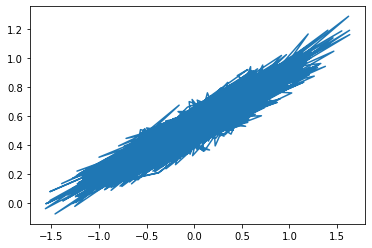

In [32]:
plt.plot(x_plot,delta_plot)

(array([[  13.,  157.,  490.,  859., 1119.,  836.,  364.,  123.,   24.,
           11.,    4.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.],
        [1974.,  183.,  172.,  153.,  177.,  158.,  139.,  148.,  114.,
          105.,  104.,   72.,   83.,   64.,   65.,   48.,   52.,   44.,
           34.,   22.,   21.,   13.,   13.,   14.,    5.,    2.,   11.,
            3.,    4.,    3.]]),
 array([-0.06939602,  0.02705268,  0.12350138,  0.21995008,  0.31639877,
         0.4128475 ,  0.5092962 ,  0.6057449 ,  0.70219356,  0.7986423 ,
         0.895091  ,  0.99153966,  1.0879884 ,  1.184437  ,  1.2808858 ,
         1.3773345 ,  1.4737831 ,  1.5702319 ,  1.6666806 ,  1.7631292 ,
         1.859578  ,  1.9560267 ,  2.0524755 ,  2.148924  ,  2.2453728 ,
         2.3418214 ,  2.43827   ,  2.534719  ,  2.6311677 ,  2.7276163 ,
         2.824065  ], dtype=float32),
 <a list of 2 BarContainer o

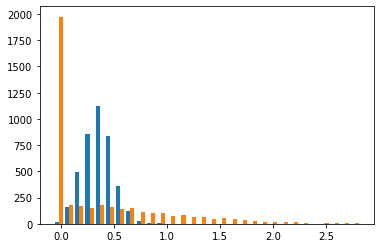

In [33]:
plt.hist([pnl_plot,payoff_plot],bins=30)